In [1]:
!pip install osgeo
!pip install geopandas
!pip install pyyaml==5.1
# !pip uninstall torch
# !pip uninstall detectron2
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html

  ERROR: Failed building wheel for osgeo
  Running setup.py clean for osgeo
Failed to build osgeo
    Running setup.py install for osgeo ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-7jl3883s/osgeo_796a78828047452dbbe5c04fa1a88251/setup.py'"'"'; __file__='"'"'/tmp/pip-install-7jl3883s/osgeo_796a78828047452dbbe5c04fa1a88251/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-45fbr4rm/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/osgeo Check the logs for full command output.
     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |██████████████████████████

#### Function to obtain a trained model in detectron2

In [ ]:
import helper
import os
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultPredictor


def load_model(model_path, threshold=0.3):
    '''
    Loads detectron2 model, returns model of type torch.nn.Module

    Parameters
    ----------
    model_path : str
        path to .pth file of model
    threshold : float \in [0,1]
        detection threshold for model

    Returns 
    ----------
    predictor : detectron2.model
    '''
    frcnn= 'faster_rcnn_R_101_FPN_3x.yaml'
    
    cfg = get_cfg() # Model Config
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/"+frcnn))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold  # for R-CNN Models
    cfg.INPUT.FORMAT = "RGB"
    
    # model_name = '2021-11-28_frcnn_200000_dukeset/model_final.pth'
    # model_path = '/content/drive/MyDrive/PyPSA_Africa_images/models/'+model_name

    model = build_model(cfg)

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(model_path)

    predictor = DefaultPredictor(cfg)
    transforms = predictor.aug

    return model, transforms

'''
if __name__ == '__main__':
    model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models', 
                                '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')
    model = load_model(model_path)
'''

"\nif __name__ == '__main__':\n    model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models', \n                                '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')\n    model = load_model(model_path)\n"

#### Build Predictor

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
import torch
import numpy as np
import cv2
from google.colab.patches import cv2_imshow


def get_true_images(dir, num, show=False):
    '''
    loads a list of images that all have a tower in them. dir has to be a directory
    only containing such images

    Parameters
    ----------
    dir : str
        directory of true examples
    num : int
        length of list returned
    show : bool
        if True, some of the examples are shown

    Returns
    ----------
    imgs : list of 3 x height x width np.ndarray
        list of obtained images
    '''

    imgs = os.listdir(dir) 
    imgs = [os.path.join(dir, img) for img in imgs]
    # randomize order
    np.random.shuffle(imgs)

    imgs = [cv2.imread(img) for img in imgs[:num]]

    if show:
        print('here are 10 images we have obtained')
        for img in imgs[:10]:
            _, ax = plt.subplots(1, 1, figsize=(4, 4))
            ax.imshow(img)
            plt.show()
    
    return imgs    


In [8]:
import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms
import helper
import numpy as np
import os
import cv2
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from image_utils import get_true_images

def build_predictor_model(threshold=0.2, model_path=None):
    '''
    Returns predictor and model using detectron2 from files stored in the
    PyPSA Africa drive

    Parameters
    ----------
    threshold : float
        detection threshold
    model_path : str
        path to .pth file

    Returns
    ---------
    predictor : detectron2.DefaultPredictor
    model : torch.nn.Module

    ''' 

    print('Building predictor from path:')
    print(model_path)

    ds_path = f'/content/drive/My Drive/PyPSA_Africa_images/datasets/duke_train/data/' 
    json_path = f'/content/drive/My Drive/PyPSA_Africa_images/datasets/duke_train/labels.json'
    ds_name = 'duke'
    
    if ds_name in DatasetCatalog.list():
        DatasetCatalog.remove(ds_name)
        MetadataCatalog.remove(ds_name)
    
    register_coco_instances(ds_name, {}, json_path, ds_path)
    
    frcnn = 'faster_rcnn_R_101_FPN_3x.yaml'
    
    cfg = get_cfg() # Model Config
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/"+frcnn))

    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = threshold
    if model_path is None:
        model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models', 
                                    '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')
    
    cfg.MODEL.WEIGHTS = model_path

    print('working with path: ', model_path)
    cfg.INPUT.FORMAT = 'BGR'

    predictor = DefaultPredictor(cfg)                                
    model = build_model(cfg)

    checkpointer = DetectionCheckpointer(model)
    checkpointer.load(model_path)

    return predictor, model


def eval_predictor(imgs, model_path=None, threshold=0.1):
    '''
    Method to check performance of model on some imgs (only chekc via plotting, does 
    not return precision scores)

    Parameters
    ----------
    imgs : list of np.array 
        images on which inference will run
    model_path : str
        path to model .pth file
    threshold : float
        cutoff for what is considered as an instance
    
    Returns
    ----------
    -

    '''

    print('Evaluating model stored under:')
    print(model_path)

    predictor, model = build_predictor_model(threshold=threshold, model_path=model_path)
    model.eval()

    for img in imgs:

        out = predictor(img)
        # out = predictor(img[:,:,::-1])
        v = Visualizer(img, MetadataCatalog.get('duke'), scale=1.5)
        out = v.draw_instance_predictions(out["instances"].to("cpu"))
        cv2_imshow(out.get_image())

        with torch.no_grad():
            
            img = predictor.aug.get_transform(img).apply_image(img)
            img = torch.as_tensor(img.astype('float32').transpose(2, 0, 1))
            x = [{'image': img, 'width': 256, 'height': 256}]
            pred = predictor.model(x)
            print(pred)

if __name__ == '__main__':
    
    duke_img_dir = '/content/drive/MyDrive/PyPSA_Africa_images/datasets/duke_val/data/'
    duke_imgs = get_true_images(duke_img_dir, 20)
    
    model_path = '/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth'
    model_path_cycle = '/content/drive/MyDrive/PyPSA_Africa_images/PISA_models/11_01_2022_fake_maxar_train/model_final.pth'
    
    print('The cycle GAN trained model')
    eval_predictor(duke_imgs, model_path=model_path_cycle)
    
    print('The regular trained model')
    eval_predictor(duke_imgs, model_path=model_path)
    
    

Output hidden; open in https://colab.research.google.com to view.

#### Function to obtain all hits for detectron2.Instances

In [ ]:
import torch
from shapely import geometry


def eval_instances(instances, ul, towers, fn, upper_left, pixel_size):
    '''
    Stores the centers of all obtained instances in a dataframe

    Parameters
    ----------
    instances : detectron2.Instances
        instances obtained from a single input image
    ul : np.ndarray
        numpy array of upper left coordinates
    towers : geopandas.GeoDataFrame
        geodataframe of instances already obtained (towers are point geometries)
    fn : str
        filename of tif currently being investigated
    upper_left, pixel_size : 
        numpy arrays to transform to coordinates

    Returns
    ----------
    towers : geopandas.GeoDataFrame
        updated geodataframe
    '''

    boxes = instances['instances'].get('pred_boxes').tensor
    boxes = boxes.resize_(boxes.size()[0], 2, 2)

    for box in boxes:

        pixels = (torch.tensor(ul) + box.mean(dim=0).to('cpu')).numpy()
        coords = upper_left + pixel_size * pixels
        point = geometry.Point(coords)
        towers = towers.append({'tif': fn, 'geometry': point}, ignore_index=True)

    return towers

In build predictor:
/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
working with path:  /content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
in eval pred: 
/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
In build predictor:
/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth
working with path:  /content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth


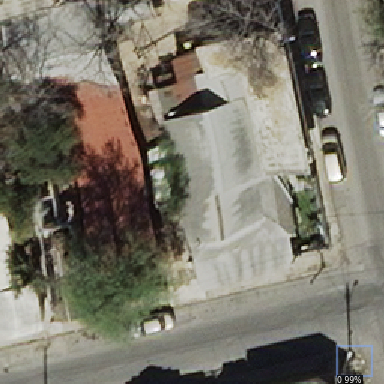

[{'instances': Instances(num_instances=1, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[224.9664, 230.8051, 248.1422, 250.5755]], device='cuda:0')), scores: tensor([0.9937], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}]


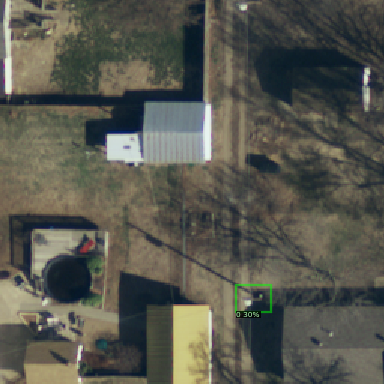

[{'instances': Instances(num_instances=1, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[157.6044, 189.8771, 180.6116, 207.8085]], device='cuda:0')), scores: tensor([0.2966], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}]


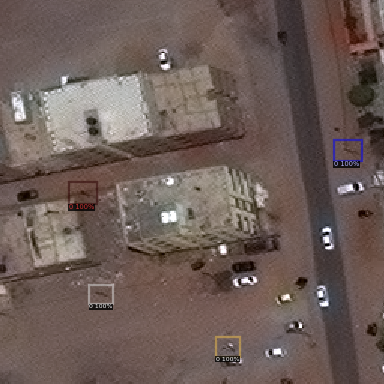

[{'instances': Instances(num_instances=4, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[ 59.5927, 190.2738,  75.6391, 202.9564],
        [222.6690,  93.0175, 241.3331, 107.6257],
        [143.9503, 224.8789, 159.6934, 237.7389],
        [ 45.7293, 121.5926,  64.8185, 136.2094]], device='cuda:0')), scores: tensor([1.0000, 0.9999, 0.9997, 0.9983], device='cuda:0'), pred_classes: tensor([0, 0, 0, 0], device='cuda:0')])}]


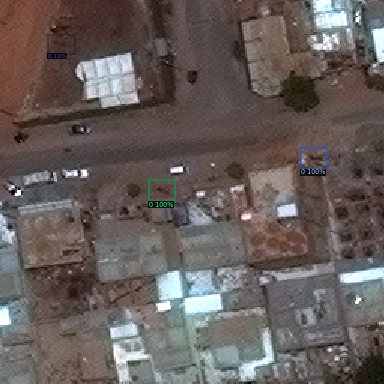

[{'instances': Instances(num_instances=3, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[ 99.0035, 120.0784, 116.6109, 134.5023],
        [200.6452,  98.6999, 218.3120, 112.9314],
        [ 31.7441,  23.4727,  50.2069,  35.6850]], device='cuda:0')), scores: tensor([0.9999, 0.9998, 0.1022], device='cuda:0'), pred_classes: tensor([0, 0, 0], device='cuda:0')])}]


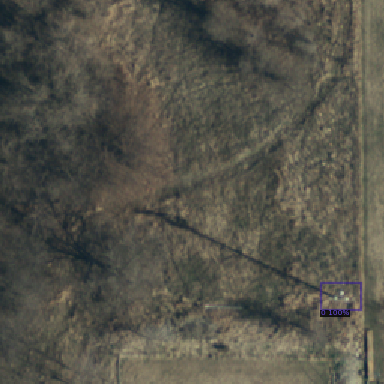

[{'instances': Instances(num_instances=1, image_height=256, image_width=256, fields=[pred_boxes: Boxes(tensor([[213.7366, 188.7733, 240.9578, 206.9419]], device='cuda:0')), scores: tensor([0.9985], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])}]
Looking at imagery in /content/drive/My Drive/PyPSA_Africa_images/maxar/ghana/raw/10500100103B0300.tif!
obtained transform:  [-2.177094300568735, 4.4493556022e-06, 0.0, 9.012619798895205, 0.0, -4.4493556022e-06]
ul:  [-2.1770943  9.0126198]
pixelz:  [ 4.4493556e-06 -4.4493556e-06]
info:  [41624, 231295]
pngs per row 162
pngs per col 903
batch size:  20


100%|█████████▉| 999/1000 [23:08<00:01,  1.39s/it]


resulting towers
                                                 tif  ...     score
0  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.507984
1  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.776677
2  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.154254
3  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.922023
4  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.256851

[5 rows x 3 columns]
                                                    tif  ...     score
1903  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.713105
1904  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.092127
1905  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.150784
1906  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.981645
1907  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.120826

[5 rows x 3 columns]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import os
import torch
from osgeo import gdal
from shapely import geometry
from torchvision import transforms
from tqdm import tqdm


def infer_towers(in_dir, 
                 tifs, 
                 out_dir, 
                 predictor, 
                 width=256, 
                 height=256, 
                 batch_size=100, 
                 stop=10,
                 folium=False,
                 add_true=None,
                 seed=None,
                 reverse=False,
                 plot_batch=False
                 ):
    '''
    Iterate over tif files and runs batch-wise inference using model. Resulting hits are stored
    in a GeoDataFrame as shapely.geometries.Point . Returns a folium map if desired


    Parameters
    ----------
    in_dir : str
        directory where the tif files can be found
    tifs : list of str
        images in tif format that should be stored
    out_dir : str
        directory where resulting .png files should be stored
    model : torch.nn.Module
        torch model to detect transmission and distribution towers
    width : int
        number of pixels on the x-axis
    height : int
        number of pixels on the y-axis
    batch_size : int
        number of examples in each model forward pass
    stop : int
        algorithms stops execution after that number of iterations
    folium : bool
        makes the function return a folium.Map object with tif shape and found towers
    add_true : None or str
        if str, some images from that dir containing towers are replacing half of the images in each batch
    seed : int
        seed to all random operations
    reverse : bool
        if True, goes over the tif from bottom to top
    plot_batch : bool
        if True, plots the images in every batch

    Returns
    ----------
    towers : geopandas.GeoDataFrame
        dataframe of towers with columns: fn (filename of tif), geometry (shapely point geometries of towers)
    tifs : geopandas.GeoDataFrame
        dataframe of tif Polygons
    (optional) m : folium.Map
        map with all datapoints from both dataframes

    '''

    np.random.seed(seed)

    # set up dataframe to store geometries of investigated tif files
    tif_df = gpd.GeoDataFrame(columns=["filename", "geometry"]).set_crs(epsg=4326)
    # list of towers that are found in tifs
    towers_df = gpd.GeoDataFrame(columns=['tif', 'geometry', 'score']).set_crs(epsg=4326)

    if not isinstance(tifs, list):
        assert isinstance(tifs, str), f'Pass list of tif filenames, instead of {tifs}'
        tifs = [tifs]
    
    tifs = [os.path.join(in_dir, tif) for tif in tifs]

    for fn in tifs:
       
        print(f'Looking at imagery in {fn}!')

        # open files
        ds = gdal.Open(fn)
        info = gdal.Info(fn, format="json")
        bands = [ds.GetRasterBand(i) for i in range(1, 4)]

        # extract relevant geographical data
        transform = info["geoTransform"]
        upper_left = np.array([transform[0], transform[3]])
        pixel_size = np.array([transform[1], transform[5]])

        tif_width = info['size'][0]
        tif_height = info['size'][1]

        # append tif extent to dataframe
        tif_geom = geometry.Polygon([info['cornerCoordinates']['upperLeft'],
                                     info['cornerCoordinates']['lowerLeft'],
                                     info['cornerCoordinates']['lowerRight'],
                                     info['cornerCoordinates']['upperRight']])
                                    
        tif_df = tif_df.append({'filename': fn, 'geometry': tif_geom}, ignore_index=True)

        print('obtained transform: ', transform)
        print('ul: ', upper_left)
        print('pixelz: ', pixel_size)

        print('info: ', info['size'])

        num_cols = tif_width // width
        num_rows = tif_height // height 

        num_batches = (num_cols * num_rows) // batch_size

        print('pngs per row {}'.format(num_cols))
        print('pngs per col {}'.format(num_rows))

        print('batch size: ', batch_size)

        # count detected instances
        instance_count = 0
        batch_count = 0

        for batch in tqdm(range(min([num_batches, stop]))):

            batch_count += 1

            if reverse:
                batch = num_batches - 1 - batch
        
            full_batch = np.zeros((height, 0, 3))

            # create a dataframe to connect detections to coordinates
            batch_df = pd.DataFrame(columns=['img_ul_x', 'img_ul_y'])

            start_png = batch * batch_size
            end_png = (1+batch) * batch_size

            start_col = start_png % num_cols
            end_col = end_png % num_cols

            start_row = start_png // num_cols
            end_row = end_png // num_cols

            # Go over rows contained in current batch
            for row in range(start_row, end_row+1):

                # obtain x coordinates of interest
                if row == start_row:
                    start_pixel_x = width * start_col
                else:
                    start_pixel_x = 0.

                if row == end_row:
                    end_pixel_x = width * end_col
                else:
                    end_pixel_x = width * num_cols
                
                row_width = int(end_pixel_x - start_pixel_x)
                start_pixel_y = row * height

                # Assign upper left corner pixel coordinates to batch_df
                img_ul_x = np.arange(start_pixel_x, end_pixel_x, width)
                img_ul_y = np.ones(row_width//width) * height * row

                appendix = pd.DataFrame({'img_ul_x': img_ul_x, 'img_ul_y': img_ul_y})
                batch_df = batch_df.append(appendix, ignore_index=True)

                row_pixels = np.ones((height, row_width, 3))
                # obtain the three bands
                for i in range(3):
                    row_pixels[:,:,i] = bands[i].ReadAsArray(start_pixel_x, start_pixel_y, row_width, height)

                full_batch = np.hstack([full_batch, row_pixels])
                
            # full_batch = full_batch[:, :, ::-1]

            # full_batch = torch.tensor(full_batch)
            full_batch = np.split(full_batch, full_batch.shape[1]//width, axis=1)
            #full_batch = torch.split(full_batch, [width for _ in range(batch_size)], dim=1)

            # print('initial shape')
            #print(len(full_batch))
            #for ex in full_batch:
            #     print(ex.shape)
            # return

            full_batch = [{'image': img, 'height': height, 'width': width} for img in full_batch]

            # for testing purposes: add images that have towers in them
            if add_true is not None:
                true_imgs = get_true_images(add_true, len(full_batch) // 2)
                for i, _ in enumerate(full_batch):
                    if i % 2 == 0: 
                        full_batch[i]['image'] = true_imgs[i//2][:, :, ::-1]

            if plot_batch:
                print('resulting batch after adding hits')
                plot_width = 20
                fig, axs = plt.subplots(1, len(full_batch), figsize=(plot_width, plot_width/len(full_batch)))
                for ax, img in zip(axs, full_batch):
                    ax.imshow(img['image'] / 255)
                plt.show()
    
            for i, img in enumerate(full_batch):

                curr_img = img['image'].astype(np.uint8)

                # _, ax = plt.subplots(1, 1, figsize=(4,4))
                # ax.imshow(curr_img)
                # plt.show()

                # print(type(curr_img))
                # print('before trafo')
                # print(curr_img.shape)
                curr_img = predictor.aug.get_transform(curr_img).apply_image(curr_img)
                curr_img = torch.as_tensor(curr_img.astype('float32').transpose(2, 0, 1))
                # print('after trafo')
                # print(curr_img.size())
                img['image'] = curr_img
                full_batch[i] = img

            # print('Investigate full batch shape')

            '''
            print('len: ', len(full_batch))
            shape = full_batch[0]['image'].size()
            print('shape of first examples: ')
            print(shape)
            for i, ex in enumerate(full_batch):
                if not shape == ex['image'].size():
                    curr_shape = ex['image'].size()
                    print(f'deviation in example {i}: {curr_shape}')
            '''


            with torch.no_grad():
                pred = predictor.model(full_batch)

            for pre, (i, row) in zip(pred, batch_df.iterrows()):

                if len(pre['instances']) > 0:
                    towers_df = eval_instances(pre, np.array([row['img_ul_x'], row['img_ul_y']]), 
                                            towers_df, fn, upper_left, pixel_size)

            if batch_count == stop: break

        print('resulting towers')
        print(towers_df.head())
        print(towers_df.tail())

    if folium: 
        import folium

        m = folium.Map(location=info['cornerCoordinates']['center'][::-1])
        
        for i, point in towers_df.geometry.iteritems():
            folium.Marker([point.coords.xy[1][0], point.coords.xy[0][0]], popup=f"Tower {i}").add_to(m)

        tifs_json = tif_df.to_json()
        tifs_json = folium.GeoJson(data=tifs_json,
                        style_function=lambda x: {'fillColor': 'orange'})
        tifs_json.add_to(m)
        
        return towers_df, tif_df, m

    else:
        return towers_df, tif_df


if __name__ == '__main__':

    # model_path = os.path.join('/content', 'drive', 'MyDrive', 'PyPSA_Africa_images', 'models', 
    #                             '2021-11-29_frcnn_180000_dukeset', 'model_final.pth')

    model_path = '/content/drive/MyDrive/PyPSA_Africa_images/notebooks/pypsa-africa/PISA_models_duke/model_final.pth'
    # model_path = '/content/drive/MyDrive/PyPSA_Africa_images/PISA_models/11_01_2022_fake_maxar_train/model_final.pth'
    detection_thresh = 0.05
    # predictor = load_predictor(model_path, threshold=detection_thresh)
    predictor, _ = build_predictor(threshold=detection_thresh, frcnn=True, model_path=model_path)
    del _

    eval_predictor(duke_imgs[:5], model_path=model_path)

    # true_dir = '/content/drive/MyDrive/PyPSA_Africa_images/datasets/maxar_train/data'
    true_dir = None

    base_dir = '/content/drive/My Drive/PyPSA_Africa_images'
    tif_names = ['10500100103B0300.tif']
    in_dir = os.path.join(base_dir, 'maxar/ghana/raw')
    out_dir = None

    seed = 1
    towers, tifs, m = infer_towers(in_dir, tif_names, out_dir, predictor, 
                             stop=1000, batch_size=20, folium=True, add_true=true_dir, seed=seed, reverse=True,
                             plot_batch=False)



                                                  tif  ...     score
3   /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.922023
5   /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.980523
13  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.991997
16  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.999351
17  /content/drive/My Drive/PyPSA_Africa_images/ma...  ...  0.998940

[5 rows x 3 columns]


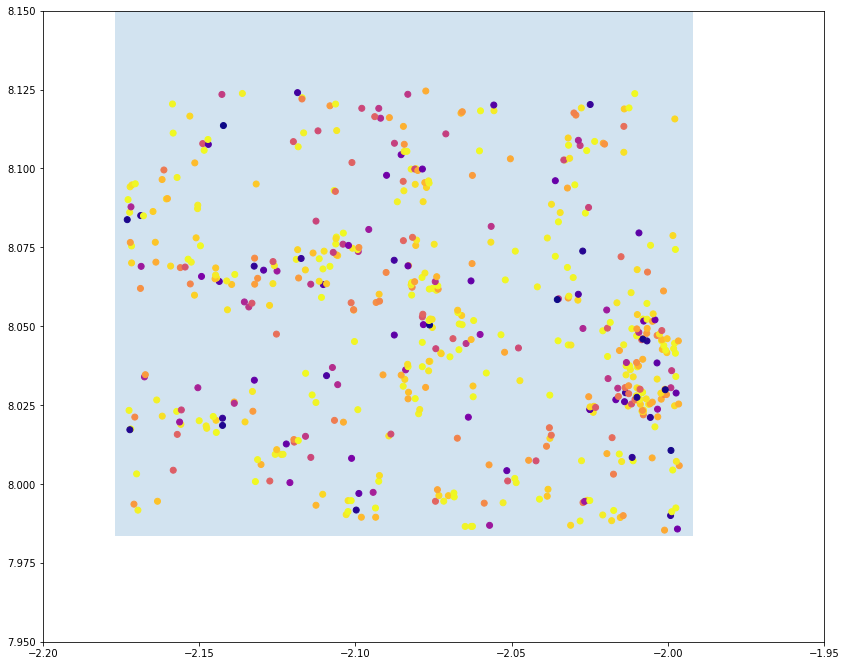

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(14, 14))

threshold = 0.9
tifs.plot(ax=ax, alpha=0.2)
towers.loc[towers['score'] > threshold].plot(ax=ax, column='score', cmap='plasma')
print(towers.loc[towers['score'] > threshold].head())
ax.set_ylim(7.95, 8.15)
ax.set_xlim(-2.2, -1.95)

plt.show()

0.23830226063728333
0.5095211267471313
0.6450020670890808
0.9985479712486267
0.5975660085678101
0.30873802304267883
0.6929610967636108
0.30581870675086975
0.1549137383699417
0.06811385601758957
0.06507309526205063
0.4472793638706207
0.36103370785713196
0.1328125149011612
0.3545618951320648
0.6464661955833435
0.9638699889183044
0.17434392869472504
0.7549711465835571
0.6970211863517761
0.9815773367881775
0.9998937845230103
0.5691407918930054
0.705547571182251
0.36411601305007935
0.17607827484607697
0.12388727813959122
0.062113456428050995
0.9907532930374146
0.09816543012857437
0.6834054589271545
0.20039469003677368
0.9990180730819702
0.09271420538425446
0.9835548996925354
0.12284646183252335
0.33983293175697327
0.12997035682201385
0.9851104021072388
0.07018628716468811
0.9981752634048462
0.06866173446178436
0.10879766196012497
0.08922753483057022
0.7879477739334106
0.09010083973407745
0.9855155944824219
0.07881369441747665
0.08383046835660934
0.05563134327530861
0.05780229717493057
0.377

(array([27., 10.,  9.,  8.,  5.,  6., 10.,  3.,  1., 17.]),
 array([0.05496445, 0.14945739, 0.24395032, 0.33844325, 0.43293619,
        0.52742912, 0.62192205, 0.71641499, 0.81090792, 0.90540085,
        0.99989378]),
 <a list of 10 Patch objects>)

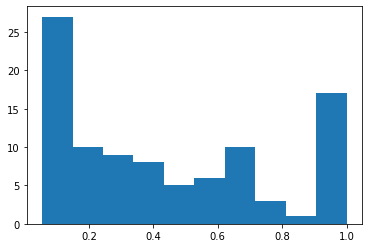

In [ ]:
for i, row in towers.iterrows():
    print(row['score'])

plt.hist(towers.score)

here are 10 images we have obtained


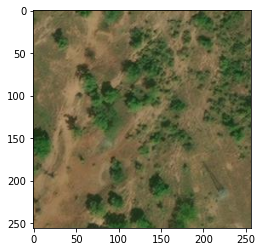

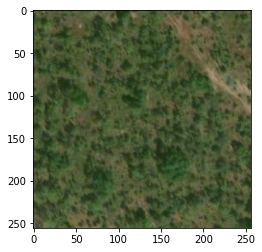

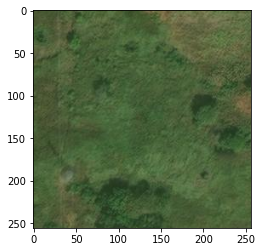

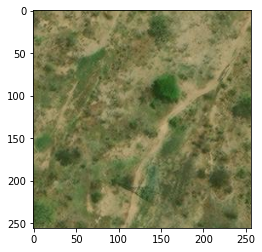

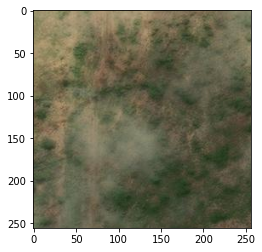

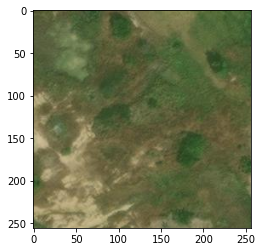

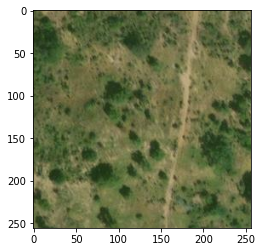

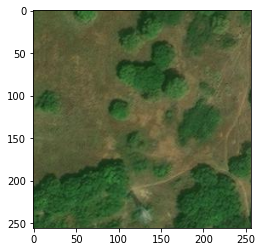

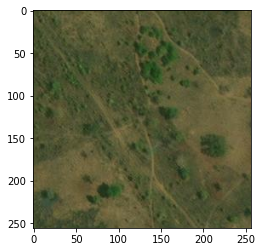

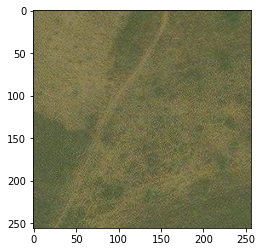

In [ ]:
dir = '/content/drive/MyDrive/PyPSA_Africa_images/datasets/maxar_train/data'
num = 20

imgs = get_true_images(dir, num, show=True)


In [ ]:
import numpy as np

np.random.seed(1)

a = np.linspace(0, 1, 10)
np.random.shuffle(a)
print(a)

[0.22222222 1.         0.66666667 0.44444444 0.         0.33333333
 0.11111111 0.77777778 0.88888889 0.55555556]


In [ ]:
import torch
from shapely import geometry


def eval_instances(instances, ul, towers, fn, upper_left, pixel_size):
    '''
    Stores the centers of all obtained instances in a dataframe

    Parameters
    ----------
    instances : detectron2.Instances
        instances obtained from a single input image
    ul : np.ndarray
        numpy array of upper left coordinates
    towers : geopandas.GeoDataFrame
        geodataframe of instances already obtained (towers are point geometries)
    fn : str
        filename of tif currently being investigated
    upper_left, pixel_size : 
        numpy arrays to transform to coordinates

    Returns
    ----------
    towers : geopandas.GeoDataFrame
        updated geodataframe
    '''

    boxes = instances['instances'].get('pred_boxes').tensor
    scores = instances['instances'].get('scores')
    boxes = boxes.resize_(boxes.size()[0], 2, 2)

    for box, score in zip(boxes, scores):

        pixels = (torch.tensor(ul) + box.mean(dim=0).to('cpu')).numpy()
        coords = upper_left + pixel_size * pixels
        point = geometry.Point(coords)
        towers = towers.append({'tif': fn, 'geometry': point, 'score': score.item()}, ignore_index=True)

    return towers


In [ ]:
for a in torch.tensor([1,2,3]):
    print(a.item())

1
2
3
